Compartmental models in NEST
==========================

### Introduction

Compartmental models are systems of coupled ODEs, used to model spatially extended neurons. Mathematically, a compartment is described by the ODE
\begin{align}\label{eq:comp}
c_i \dot{v}_i(t) = g_{L,i} \, (e_{L,i} - v_i(t)) + \sum_{n \in {neighbours}} g_{C,in} \, (v_{n}(t) - v_i(t)) + \text{channel currents} + \text{synapse currents}, 
\end{align}
with $c_i$ the capacitance of the compartment, $g_{L,i}$ resp. $e_{L,i}$ its leak conductance resp. reversal and $g_{C,in}$ its coupling conductance to the neighbouring compartment $n$. A morphological model consists of a number of compartments, coupled to each other as a tree graph. The structure of the tree thus determines the coupling between compartments: only compartments that share an edge have a non-zero coupling conductance between them. Compartments can further be equipped with ion channels and synaptic input currents.

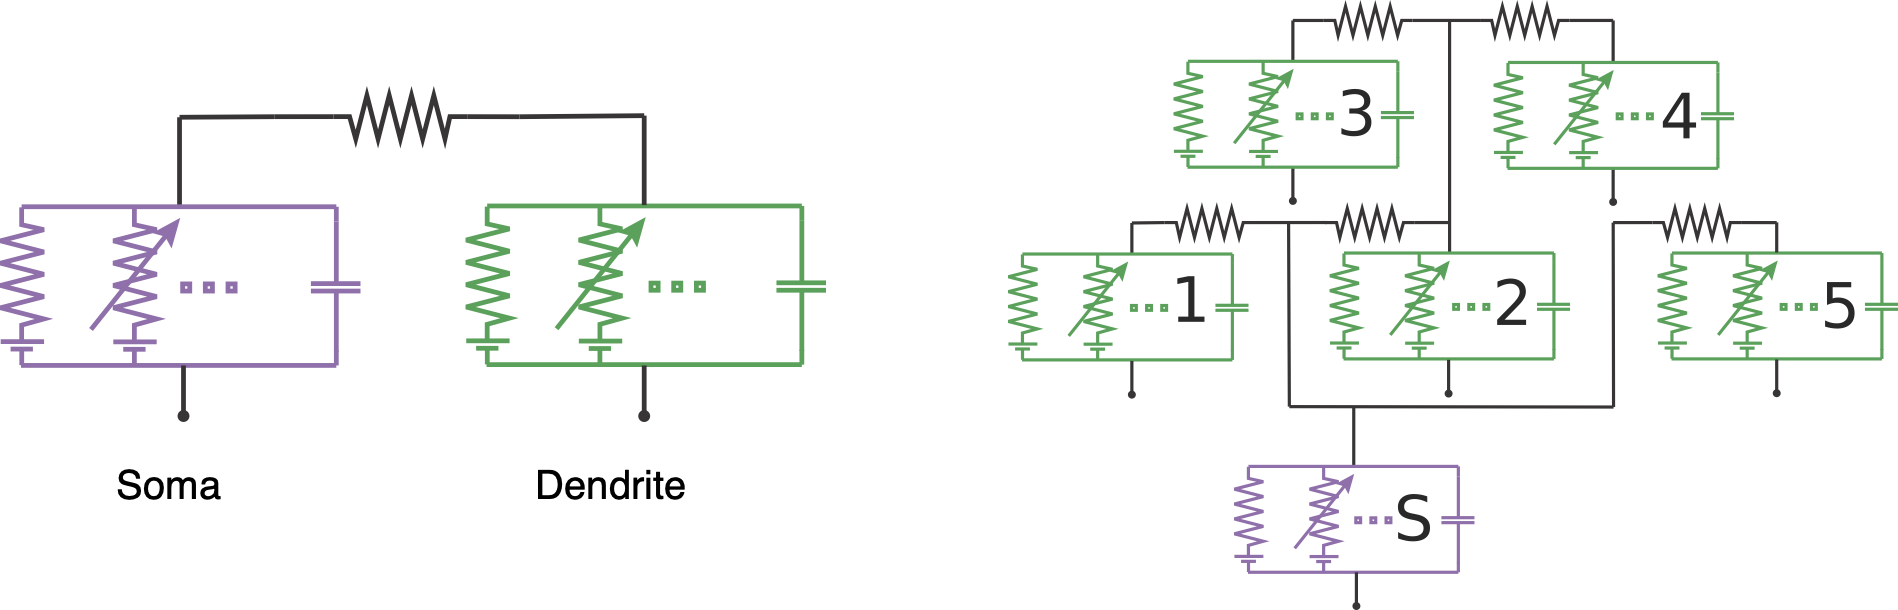

Compartmental models are supported in NEST through the nest model [`'cm_default'`](https://nest-simulator.readthedocs.io/en/v3.3/models/cm_default.html). This model implements default sodium and potassium channels and four synaptic receptor types. The compartmental model architecture further supports configurable compartmental layouts, defined by the user at runtime. While most simulators (NEURON, Arbor) have chosen a high-level API, where morphologies are loaded from data files and converted internally to systems of compartmental ODEs, NEST, with its focus on simplified neuron models, has chosen a low-level interface, where compartments are added explicitely. In this tutorial, we will define a neuron model by explicitly adding compartments, and we will simulate this neuron model to produce a number of dendritic computations.

### Complementary tools

##### NESTML

The default compartmental model can be customized through [NESTML](https://nestml.readthedocs.io/en/latest/). Custom ion channels and receptor currents can be defined in NESTML, and will be translated into their own custom compartmental model. In another tutorial, we will describe how such models can be defined and compiled. Interaction with such models is identical to the default compartmental model described here, except that the default ion channel parameter fields and state variable fields will be replaced with the ones define in the NESTML model.

##### NEAT

While the low-level API to compartmental models in NEST is great for exploring how specific parameters influence the interaction between compartments, a number of use cases requires a high-level API, especially in data-driven modelling. The NEural Analysis Toolbox ([NEAT](https://neatdend.readthedocs.io/en/latest/)) implements the possibility to load morphologies from data files and to specify physiological parameters through high-level function (e.g. for the whole neuron). It also implements a number of algorithms to analyze neuronal morphologies, notably to simplify them into models with few compartments. An automatic pipeline to export models to NEST is under construction. In the meantime, simplified model parameters can already be extracted from NEAT trees and directly transferred to NEST through user-defined code using the NEST API.

### Model specification


To start configuring a compartmental model, we import `nest` and create an empty model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nest
cm = nest.Create("cm_default")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@e0f8991aa
 Built: Jun 21 2022 10:19:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Note that contrarily to other model types, the model `cm` is actually empty. It has no compartments. Trying to connect anything to it will give an error.

In [2]:
try:
    sg = nest.Create('spike_generator', 1)
    nest.Connect(sg, cm)
except Exception as e:
    print(e)

UnknownPort in SLI function Connect_g_g_D_D: Port with id 0 does not exist. Valid spike receptor ports for cm_default are in [0, 0[.


First, we will define the parameters of our compartments. Note that the parameters defined below are extracted using NEAT, to represent a Layer 5 Pyramidal cell's soma, and a distal dendritic compartment on the basal dendrites.

In [3]:
soma_params = {
    # passive parameters
    'C_m':  0.330880516,        # [nF] Capacitance
    'g_C': 0.0,                 # soma has no parent
    'g_L':  0.015135876677,     # [uS] Leak conductance
    'e_L': -75.00046388760929,  # [mV] leak reversal
    # ion channel params
    'gbar_Na': 22.036637488000, # [nS] Na maximal conductance
    'e_Na': 50.,                # [mV] Na reversal
    'gbar_K': 9.871382640833,   # [nS] K maximal conductance
    'e_K': -85.                 # [mV] K reversal
}
dend_params = {
    # passive parameters
    'C_m': 0.002124942,         # [nF] Capacitance
    'g_C': 0.000552611865,      # [uS] Coupling with parent
    'g_L': 0.000072191148,      # [uS] Leak conductance
    'e_L': -75.0,               # [mV] Leak reversal
}

We will then create compartments for our model:

In [4]:
cm.compartments = [
    {"parent_idx": -1, "params": soma_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
]

In this case, we have created a somatic compartment and five dendritic compartments, each connected to the soma. This corresponds to a simplified dendritic configuration with five branches. Compartments are assigned indices in the order in which they figure in the provided list, with this constraint that the somatic compartment always has to be added first. By consequence, the somatic compartment has index 0, and dendritic compartments have indices 1 to 5. Thus, specifying `"parent_idx": 0` means that these dendritic compartments have the soma as parent in the tree graph, resulting in the following layout:

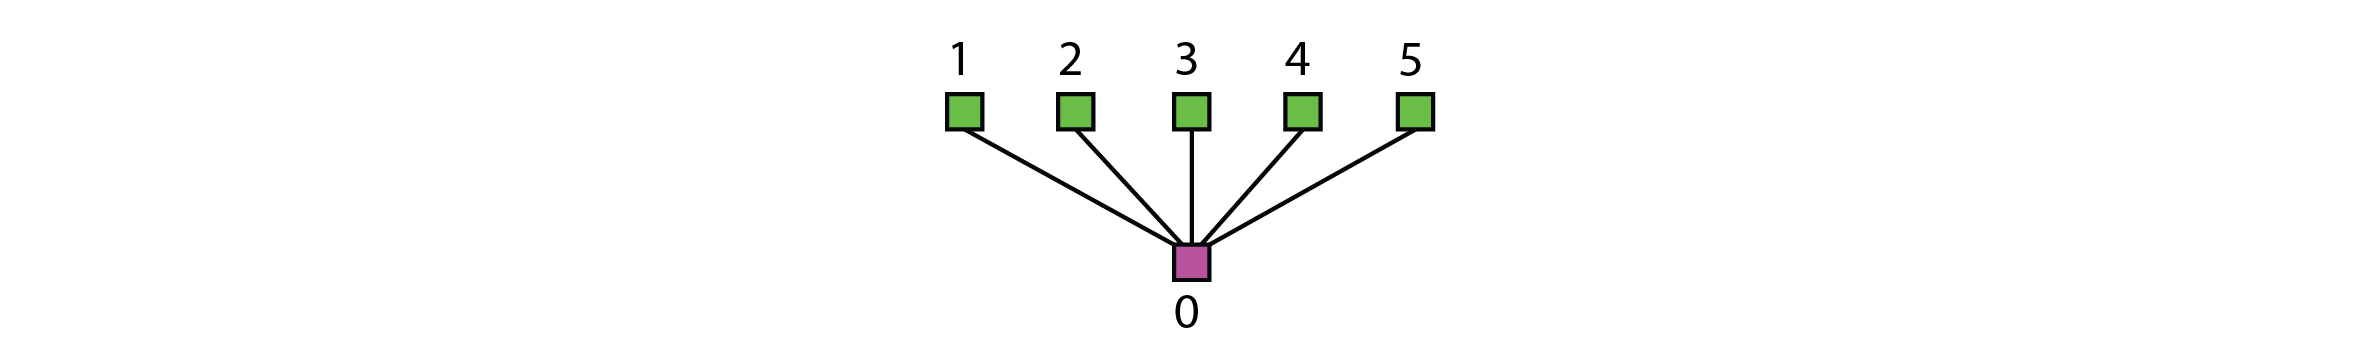

Note that the coupling conductance between compartments $i$ and $j$ is always symmetric (i.e. $g_{C,ij} = g_{C,ji}$). Thus, we only define the coupling between two compartments once, when a given compartment is added (parameter `'g_C'`), and it is understood that this is the coupling between the current compartment and its parent.

Further, we remark that care should be taken that the `"parent_idx"` for a given compartment is already in the tree when the compartment is added. Since compartments are added in the order in which they appear in the list, valid parent indices should always be smaller than the index of current entry. For example, the following code will give an error:

In [5]:
cm_test = nest.Create("cm_default")
try:
    cm_test.compartments = [
        {"parent_idx": 0},
        {"parent_idx": -1}
    ]
except Exception as e:
    print(e)
    
nest.ResetKernel()

UnknownCompartment in SLI function SetStatus_id: Compartment 0 does not exist in tree, but was specified as a parent compartment.


Finally, we note that not specifying parameters in the `"params"` entry results in the [default parameters values](https://nest-simulator.readthedocs.io/en/v3.3/models/cm_default.html) being used in the compartment. As the default conductances are 0 for the ion channels, the following defines a passive model:

In [6]:
soma_params_pas = {key: val for key, val in soma_params.items() if key in ["C_m", "g_C", "g_L", "e_L"]}

cm_pas = nest.Create('cm_default')
cm_pas.compartments = [
    {"parent_idx": -1, "params": soma_params_pas},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
]

### Connecting synaptic inputs

Now, we will connect synaptic inputs to the compartments. To do so, we must equip compartments with receptors. A receptor is assigned to a given compartment, which is specified by its index (`"comp_idx"` entry), which in turn corresponds to the order in which the compartments were added. In the following, we will add a single an AMPA receptor to each dendritic compartment, and an AMPA+NMDA receptor:

In [7]:
cm_pas.receptors = [
    # AMPA receptors to all dendritic compartments
    {"comp_idx": 1, "receptor_type": "AMPA"},
    {"comp_idx": 2, "receptor_type": "AMPA"},
    {"comp_idx": 3, "receptor_type": "AMPA"},
    {"comp_idx": 4, "receptor_type": "AMPA"},
    {"comp_idx": 5, "receptor_type": "AMPA"},
    # AMPA+NMDA receptors to all dendritic compartments
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 2, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 3, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 4, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 5, "receptor_type": "AMPA_NMDA"},
]

Receptors are assigned indices in the same way as compartments: based on the order in which they are added. Thus, a receptor index corresponds to its position in the list. In this case, the `"AMPA"` receptors have receptor indices 0 to 4, and the `"AMPA_NMDA"` receptors indices 5 to 9. If receptors parameters that differ from the default values are needed, they can be specified by adding a `"params"` entry to the status dictionary. E.g. to change the NMDA-ratio of receptor 5 from the default of 1 to 2, we would replace
```
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA"},
```
with
```
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA", "params": {'NMDA_ratio': 2.}},
```

Now, we have fully specified the compartmental model and are ready to connect an input to it. We create a spike generator and connect it receptor 0. We must specify the receptor index under the `"receptor_type"` entry of the `syn_spec` dictionary:

In [8]:
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
nest.Connect(
    sg, cm_pas, 
    syn_spec={
        'synapse_model': 'static_synapse', 
        'weight': .001, # uS
        'delay': 0.5, 
        'receptor_type': 0,
    }
)

### Recording

To record state variables of the model, we suffix the state variable name either with the compartment index -- if the state variable is the voltage or associated to an ion channel -- or the receptor index -- if the state variable is associated with a receptor. Thus, in the `record_from` attribute of a multimeter, we specify
```
"{state_variable_name}{compartment_index}"
```
for the compartmental voltage or ion channel state variables, and
```
"{state_variable_name}{receptor_index}"
```
for the receptor state variables.

Valid state variable names in the default model are:

|**Voltage** | **ion channels**|      | **receptors** |           |           |              |
|------------|-----------------|------|---------------|-----------|-----------|--------------|
|            | *Na*            |*K*   | *AMPA*        | *GABA*    | *NMDA*    | *AMPA_NMDA*  |
|v_comp      |m_Na_            |n_K_  | g_r_AMPA_     | g_r_GABA_ | g_r_NMDA_ | g_r_AN_AMPA_ |
|            |h_Na_            |      | g_d_AMPA_     | g_d_GABA_ | g_d_NMDA_ | g_d_AN_AMPA_ |
|            |                 |      |               |           |           | g_r_AN_NMDA_ |
|            |                 |      |               |           |           | g_d_AN_NMDA_ |

With the following multimeter, we record all voltages

In [9]:
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm_pas)

Let's now run this simulation and plot the results


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


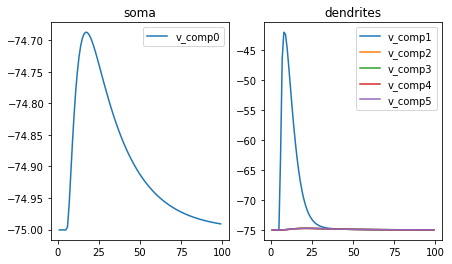

In [10]:
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

plt.figure(figsize=(7,4))

ax1 = plt.subplot(121)
ax1.set_title("soma")
plt.plot(res['times'], res['v_comp0'], label='v_comp0')
plt.legend(loc=0)

ax2 = plt.subplot(122)
ax2.set_title("dendrites")
plt.plot(res['times'], res['v_comp1'], label='v_comp1')
plt.plot(res['times'], res['v_comp2'], label='v_comp2')
plt.plot(res['times'], res['v_comp3'], label='v_comp3')
plt.plot(res['times'], res['v_comp4'], label='v_comp4')
plt.plot(res['times'], res['v_comp5'], label='v_comp5')
plt.legend(loc=0)

plt.show()

We can see that with the compartment parameters chosen here, the dendritic compartment is very well isolated from the somatic compartment and the other dendrites. Only a small part of the dendritic depolarization arrives at the soma and other dendritic compartments.

Before proceeding, let us capture some neuron creation routines in convenient functions

In [11]:
def create_neuron_w_dend_receptors(passive_soma=False, AMPA_params={}, AMPA_NMDA_params={}):
    if passive_soma:
        soma_params_ = soma_params_pas
    else:
        soma_params_ = soma_params
    
    # define the model with its compartments
    cm = nest.Create('cm_default')
    cm.compartments = [
        {"parent_idx": -1, "params": soma_params_},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
    ]
    # add the dendritic receptors
    cm.receptors = [
        # AMPA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 2, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 3, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 4, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 5, "receptor_type": "AMPA", "params": AMPA_params},
        # AMPA+NMDA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 2, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 3, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 4, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 5, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
    ]
    
    return cm

def plot_dend_and_soma(res):
    plt.figure(figsize=(7,4))

    ax1 = plt.subplot(121)
    ax1.set_title("soma")
    plt.plot(res['times'], res['v_comp0'], label='v_comp0')
    plt.legend(loc=0)

    ax2 = plt.subplot(122)
    ax2.set_title("dendrites")
    plt.plot(res['times'], res['v_comp1'], label='v_comp1')
    plt.plot(res['times'], res['v_comp2'], label='v_comp2')
    plt.plot(res['times'], res['v_comp3'], label='v_comp3')
    plt.plot(res['times'], res['v_comp4'], label='v_comp4')
    plt.plot(res['times'], res['v_comp5'], label='v_comp5')
    plt.legend(loc=0)

    plt.show()

### Dendritic computation 1: sublinear summation

Now that the basics are understood, let's try to see if we can implement dendritic computations. First, we'll compare summation of inputs at the AMPA synapses. A single PSP induced a max depolarization of 

In [12]:
delta_v = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"{delta_v:.5f} mV")

0.31301 mV


What is the maximum somatic depolarization if all dendritic AMPA receptors are activated at the same time? To model this distributed input scenario, we connect a spike generator to the AMPA receptors and then simulate the model.


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


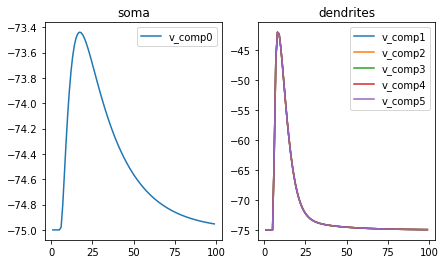

For distributed input, we obtain a somatic depolarization of 1.56126 mV, very close to the linear sum of 1.56507 mV


In [13]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for receptor_idx in range(5):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .001, # uS
            'delay': 0.5, 
            'receptor_type': receptor_idx,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_distr = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_distr:.5f} mV, "\
      f"very close to the linear sum of {5*delta_v:.5f} mV")

On the other hand, five spikes might target a single branch. We connect the spike generator five times to the same compartment to simulate this concentrated input scenario.


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


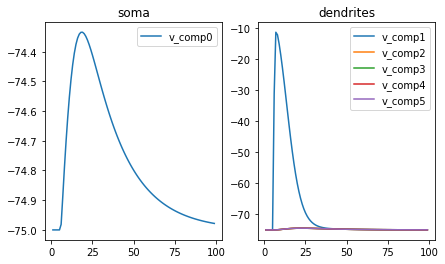

For concentrated input, we obtain a somatic depolarization of 0.66618 mV, much less than the linear sum of 1.56507 mV


In [14]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for _ in range(5):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .001, # uS
            'delay': 0.5, 
            'receptor_type': 0,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_conc = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For concentrated input, we obtain a somatic depolarization of {delta_v_conc:.5f} mV, "\
      f"much less than the linear sum of {5*delta_v:.5f} mV")

We thus confirmed the result that spread out dendritic inputs sum linearly, but that concentrated dendritic inputs without active reinforcement sum sub-linearly.

### Dendritic computation 2: Supra-linear summation

Cortical and hippocampal neurons express NMDA-channels at their excitatory synapses. Through a voltage dependent Mg-block, these channels induce supralinear responses in the dendrites of cortical neurons. We repeat the previous simulations, but use a the AMPA+NMDA receptor type.

First, we simulate a single input.


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


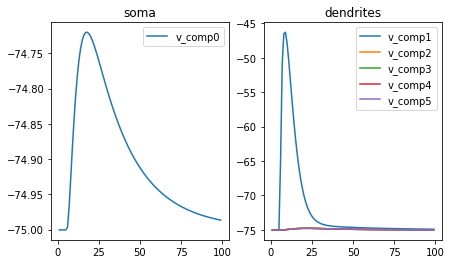

For a single input to an AMPA+NMDA synapse, we obtain a PSP amplitude of 0.28044 mV


In [15]:
AMPA_NMDA_receptor_params = {"NMDA_ratio": 2., "tau_r_NMDA": 10.}

nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
nest.Connect(
    sg, cm, 
    syn_spec={
        'synapse_model': 'static_synapse', 
        'weight': .0008, # uS
        'delay': 0.5, 
        'receptor_type': 5, # connect to the AMPA_NMDA synapse in compartment 1
    }
)

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For a single input to an AMPA+NMDA synapse, we obtain a PSP amplitude of {delta_v_nmda:.5f} mV")

Then, we perform this simulation for distributed input.


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


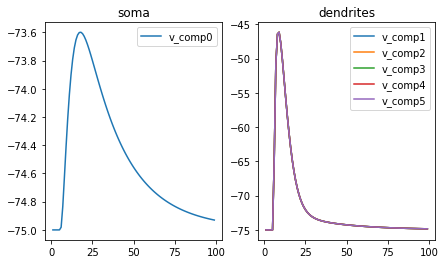

For distributed input, we obtain a somatic depolarization of 1.40102 mV, very close to the linear sum of 1.40218 mV


In [16]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for receptor_idx in range(5,10):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .0008, # uS
            'delay': 0.5, 
            'receptor_type': receptor_idx,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda_distr = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_nmda_distr:.5f} mV, "\
      f"very close to the linear sum of {5*delta_v_nmda:.5f} mV")

Finally, we perform the simulation for concentrated inputs to the NMDA synapses.


Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


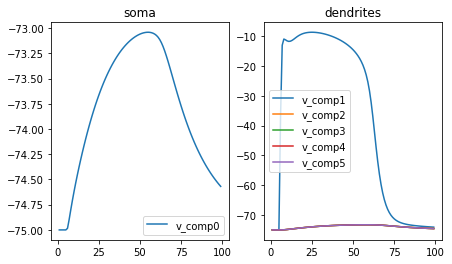

For distributed input, we obtain a somatic depolarization of 1.95959 mV, much larger than the linear sum of 1.40218 mV


In [17]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for _ in range(5,10):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .0008, # uS
            'delay': 0.5, 
            'receptor_type': 5,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda_conc = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_nmda_conc:.5f} mV, "\
      f"much larger than the linear sum of {5*delta_v_nmda:.5f} mV")

Thus, we have confirmed the result that inputs to the branches of cortical layer 5 pyramidal cells can sum supra-linearly, through activation of the NMDA receptor.

### Output spiking

Finally, let us see if we can estimate the number of distal basal branches that need to generate coincident NMDA spikes in order to generate an output spike. To do so, we implement a routine to create a compartmental model with a configurable number of dendritic subunits.

In [18]:
def create_neuron_w_n_dends(n, AMPA_NMDA_params={}):
    compartments_list = \
        [{"parent_idx": -1, "params": soma_params}] + \
        [{"parent_idx":  0, "params": dend_params} for _ in range(n)]
    
    # define the model with its compartments
    cm = nest.Create('cm_default')
    cm.compartments = compartments_list
    # add the dendritic receptors
    cm.receptors = [
        # AMPA+NMDA receptors to all dendritic compartments
        {"comp_idx": ii, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params} \
        for ii in range(1,n+1)
    ]
    
    return cm

Next, we create a while loop to increase the number of branches until an output spike is generated. To each branch, we connect a spike generator that transmits 5 inputs, to generate local dendritic spikes. We connect a spike recorder to record the output spikes at the soma. 

Since this is the first example with active ion channels with non-zero conductance, we also illustrate how to record their state variables. Note that these state variables could in principle also be recorded for the passive model, but their state will not change during the simulation.

In [19]:
n_out_spikes = 0
n_dend = 5

while n_out_spikes < 1:
    n_dend += 1
    nest.ResetKernel()
    
    # create the neuron model
    cm = create_neuron_w_n_dends(n_dend, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

    # create and connect the spike generator
    sg = nest.Create('spike_generator', 1, {'spike_times': [4.6,4.8,5.,5.2,5.4]})
    for receptor_idx in range(n_dend):
        nest.Connect(
            sg, cm, 
            syn_spec={
                'synapse_model': 'static_synapse', 
                'weight': .0008 * (.8 + .4 * np.random.rand()), # uS, add some randomness to the weights
                'delay': 0.5, 
                'receptor_type': receptor_idx,
            }
        )
    
    # create a spike recorder
    sr = nest.Create('spike_recorder')
    nest.Connect(cm, sr)

    # create the recorder, note that now we added the 
    # state variables of the somatic ion channels to
    # the `record_from` field of the multimeter.
    mm = nest.Create('multimeter', 1)
    mm.record_from = \
        [f'v_comp{ii}' for ii in range(n_dend+1)] + \
        ['m_Na_0', 'h_Na_0', 'n_K_0'] 
    nest.Connect(mm, cm)

    # simulate the model
    nest.Simulate(100.)
    res = mm.events
    
    # to assess whether an output spike was generated,
    # we probe the event count of the spike recorder
    n_out_spikes = sr.n_events
    
print(f"The Layer 5 pyramidal cell model produced an output spike when " \
      f"{n_dend} dendritic compartments where present and activated")

The Layer 5 pyramidal cell model produced an output spike when 6 dendritic compartments where present and activated
Jun 22 09:58:26 NodeManager::prepare_nodes [Info]: 

    Preparing 4 nodes for simulation.

Jun 22 09:58:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Jun 22 09:58:26 SimulationManager::run [Info]: 
    Simulation finished.


Finally, we plot all recordings.

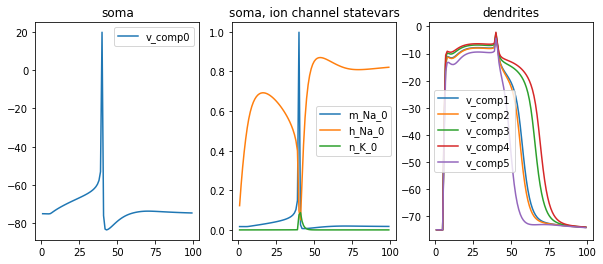

In [20]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(131)
ax1.set_title("soma")
plt.plot(res['times'], res['v_comp0'], label='v_comp0')
plt.legend(loc=0)

ax1 = plt.subplot(132)
ax1.set_title("soma, ion channel statevars")
plt.plot(res['times'], res['m_Na_0'], label='m_Na_0')
plt.plot(res['times'], res['h_Na_0'], label='h_Na_0')
plt.plot(res['times'], res['n_K_0'], label='n_K_0')
plt.legend(loc=0)

ax2 = plt.subplot(133)
ax2.set_title("dendrites")
plt.plot(res['times'], res['v_comp1'], label='v_comp1')
plt.plot(res['times'], res['v_comp2'], label='v_comp2')
plt.plot(res['times'], res['v_comp3'], label='v_comp3')
plt.plot(res['times'], res['v_comp4'], label='v_comp4')
plt.plot(res['times'], res['v_comp5'], label='v_comp5')
plt.legend(loc=0)

plt.show()